In [1]:
%matplotlib inline

In [2]:
import json
import pandas as pd
from pathlib import Path

def load_summary_results(save_root):
    save_root = Path(save_root)
    session_folders = [f for f in save_root.iterdir() if f.is_dir()]
    
    summary_data = []

    for folder in session_folders:
        json_file = folder / "tongue_quality_stats.json"
        if not json_file.exists():
            continue
        
        with open(json_file, "r") as f:
            results = json.load(f)
        
        # Flatten percentiles into columns
        row = {
            "session_id": results["session_id"],
            "coverage_pct": results["coverage_pct"],
        }
        for metric, pct_dict in results["percentiles"].items():
            for pct, val in pct_dict.items():
                row[f"{metric}_{pct}"] = val

        summary_data.append(row)
    
    return pd.DataFrame(summary_data)

# Example usage
save_root = "/root/capsule/scratch/session_analysis"
summary_df = load_summary_results(save_root)



In [3]:
summary_df.head()

,session_id,coverage_pct,dropped_frames_n_0.0,dropped_frames_n_0.1,dropped_frames_n_0.25,dropped_frames_n_0.5,dropped_frames_n_0.75,dropped_frames_n_0.9,dropped_frames_n_1.0,duration_0.0,duration_0.1,duration_0.25,duration_0.5,duration_0.75,duration_0.9,duration_1.0
0,behavior_758017_2025-02-04_11-57-33,71.207901,0,0,0,0,2,5,30,0.0,0.004000,0.046016,0.061984,0.076000,0.098016,0.366016
1,behavior_761038_2025-04-15_10-24-57,99.704142,0,0,0,0,0,1,21,0.0,0.042016,0.060000,0.072000,0.084000,0.108000,0.221984
2,behavior_754897_2025-03-13_11-20-39,51.868460,0,0,0,0,2,6,32,0.0,0.002016,0.013984,0.062016,0.080000,0.094016,0.168000
3,behavior_754897_2025-03-11_12-07-35,49.228944,0,0,0,0,4,9,28,0.0,0.000000,0.004000,0.020000,0.060000,0.080000,0.176000
4,behavior_751766_2025-02-11_11-53-32,82.926262,0,0,0,1,4,9,29,0.0,0.005984,0.037984,0.065984,0.085984,0.104000,0.240000


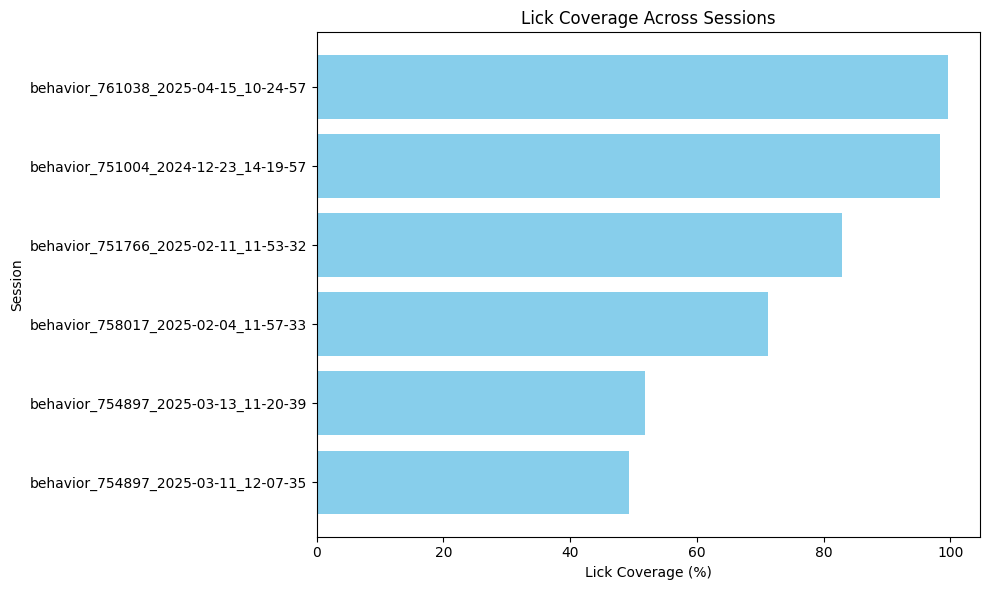

In [4]:
import matplotlib.pyplot as plt

summary_df_sorted = summary_df.sort_values("coverage_pct")

plt.figure(figsize=(10, 6))
plt.barh(summary_df_sorted["session_id"], summary_df_sorted["coverage_pct"], color="skyblue")
plt.xlabel("Lick Coverage (%)")
plt.ylabel("Session")
plt.title("Lick Coverage Across Sessions")
plt.tight_layout()
plt.show()


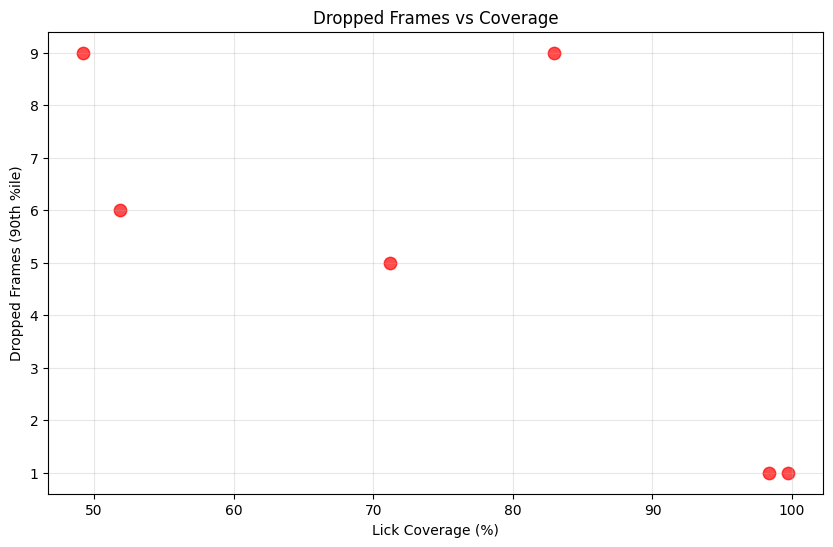

In [5]:
plt.figure(figsize=(10, 6))
plt.scatter(summary_df["coverage_pct"], summary_df["dropped_frames_n_0.9"], color="red", s=80, alpha=0.7)
plt.xlabel("Lick Coverage (%)")
plt.ylabel("Dropped Frames (90th %ile)")
plt.title("Dropped Frames vs Coverage")
plt.grid(True, alpha=0.3)
plt.show()


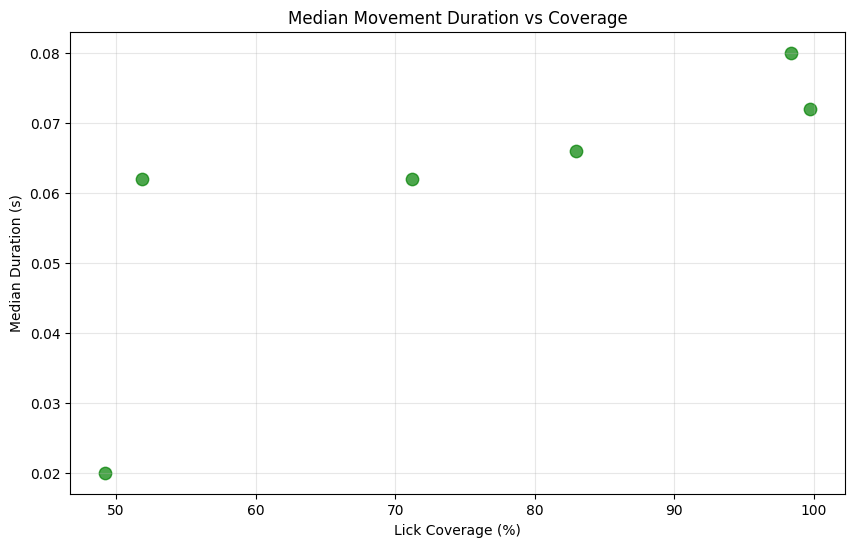

In [6]:
plt.figure(figsize=(10, 6))
plt.scatter(summary_df["coverage_pct"], summary_df["duration_0.5"], color="green", s=80, alpha=0.7)
plt.xlabel("Lick Coverage (%)")
plt.ylabel("Median Duration (s)")
plt.title("Median Movement Duration vs Coverage")
plt.grid(True, alpha=0.3)
plt.show()


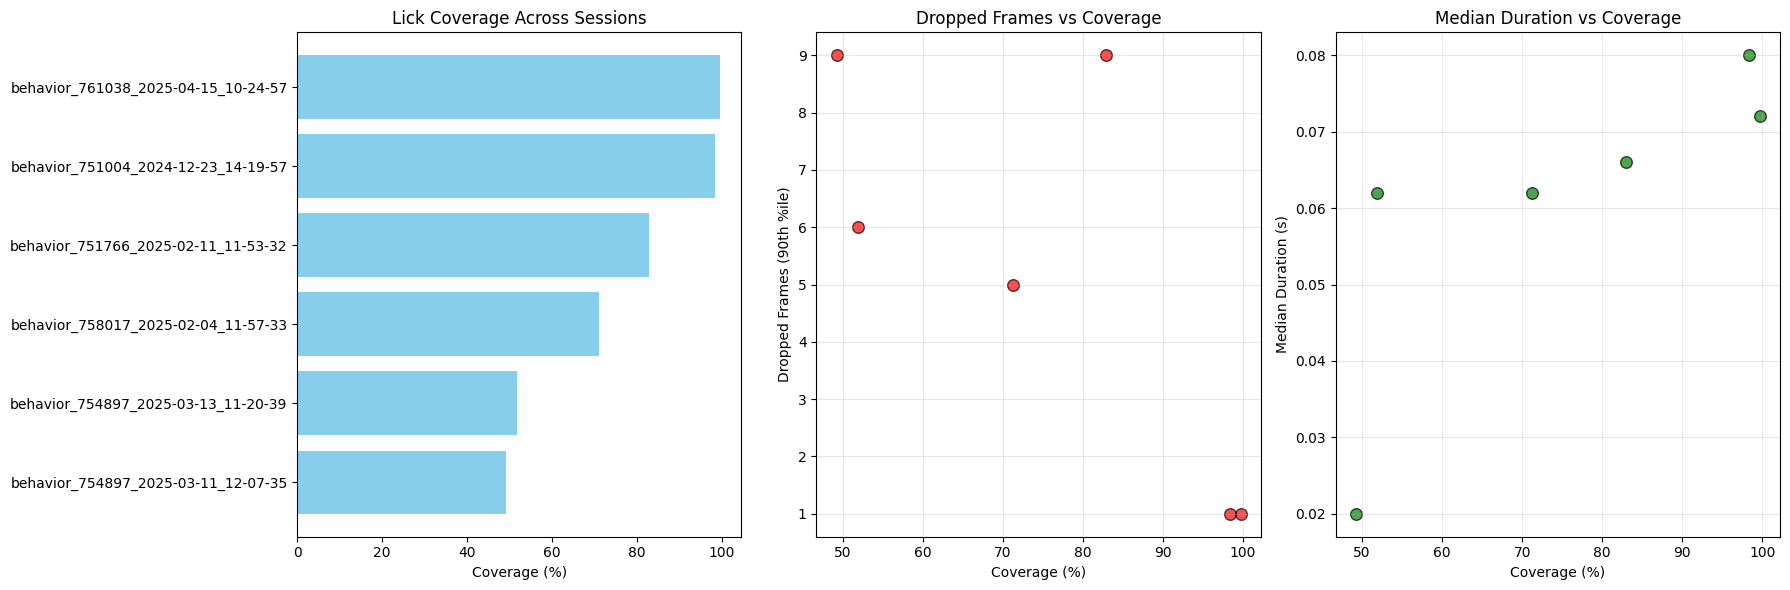

In [7]:

def plot_combined_summary(summary_df):
    # Sort by coverage for barplot
    summary_df_sorted = summary_df.sort_values("coverage_pct")

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # --- 1) Coverage Barplot ---
    axes[0].barh(summary_df_sorted["session_id"], summary_df_sorted["coverage_pct"], color="skyblue")
    axes[0].set_xlabel("Coverage (%)")
    axes[0].set_title("Lick Coverage Across Sessions")

    # --- 2) Dropped Frames vs Coverage ---
    axes[1].scatter(summary_df["coverage_pct"], summary_df["dropped_frames_n_0.9"], 
                    color="red", s=70, alpha=0.7, edgecolor='k')
    axes[1].set_xlabel("Coverage (%)")
    axes[1].set_ylabel("Dropped Frames (90th %ile)")
    axes[1].set_title("Dropped Frames vs Coverage")
    axes[1].grid(True, alpha=0.3)

    # --- 3) Duration vs Coverage ---
    axes[2].scatter(summary_df["coverage_pct"], summary_df["duration_0.5"], 
                    color="green", s=70, alpha=0.7, edgecolor='k')
    axes[2].set_xlabel("Coverage (%)")
    axes[2].set_ylabel("Median Duration (s)")
    axes[2].set_title("Median Duration vs Coverage")
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Example usage:
plot_combined_summary(summary_df)


In [8]:
# Example usage
save_root = "/root/capsule/scratch/session_analysis"
summary_df = load_summary_results(save_root)
summary_df_ood = summary_df[summary_df["session_id"] != "behavior_751004_2024-12-23_14-19-57"]

# Example usage
save_root2 = "/root/capsule/scratch/session_analysis_in_distribution"
summary_df_id = load_summary_results(save_root2)


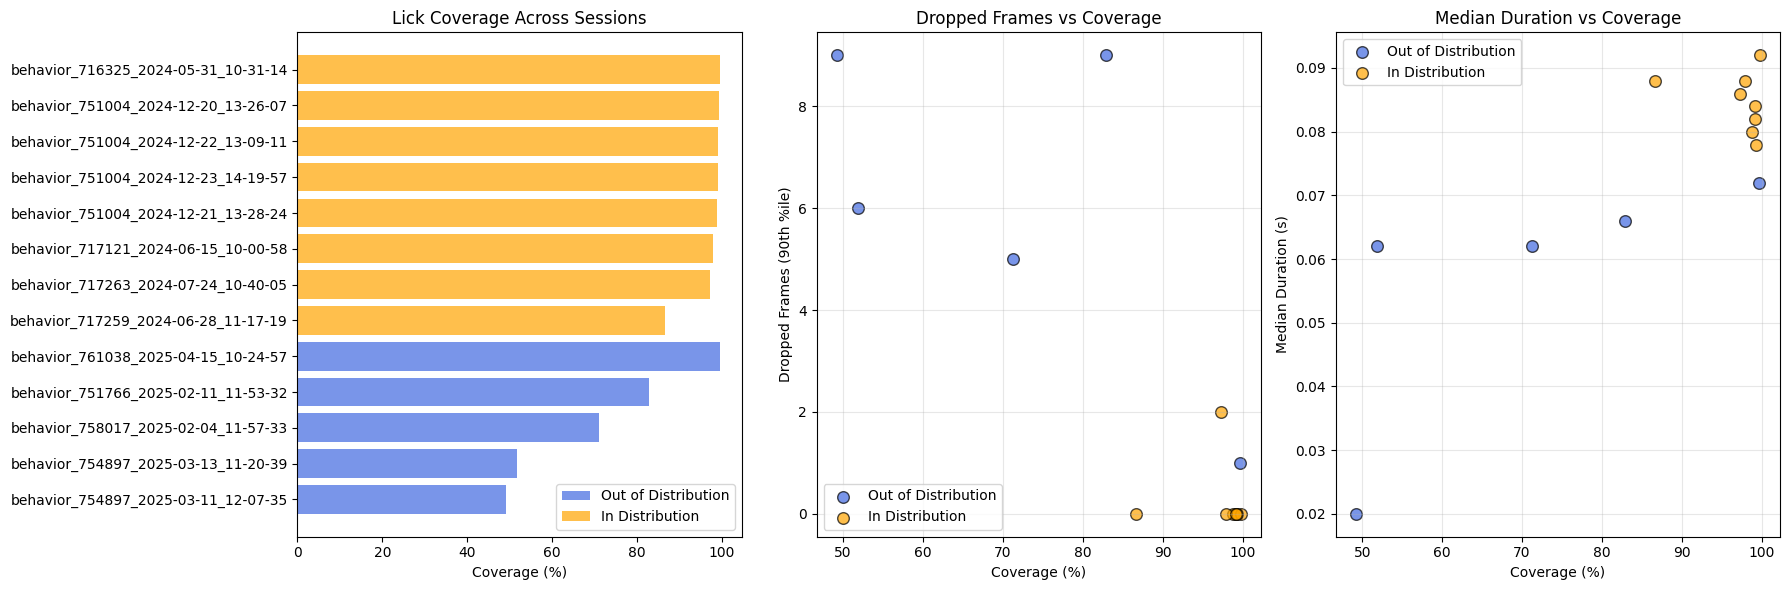

In [9]:
def plot_combined_summary_compare(summary_df1, summary_df2, label1="Out of Distribution", label2="In Distribution"):
    # Sort by coverage for barplot
    summary_df1_sorted = summary_df1.sort_values("coverage_pct")
    summary_df2_sorted = summary_df2.sort_values("coverage_pct")

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # --- 1) Coverage Barplot ---
    axes[0].barh(summary_df1_sorted["session_id"], summary_df1_sorted["coverage_pct"], 
                 color="royalblue", label=label1, alpha=0.7)
    axes[0].barh(summary_df2_sorted["session_id"], summary_df2_sorted["coverage_pct"], 
                 color="orange", label=label2, alpha=0.7)
    axes[0].set_xlabel("Coverage (%)")
    axes[0].set_title("Lick Coverage Across Sessions")
    axes[0].legend()

    # --- 2) Dropped Frames vs Coverage ---
    axes[1].scatter(summary_df1["coverage_pct"], summary_df1["dropped_frames_n_0.9"], 
                    color="royalblue", s=70, alpha=0.7, edgecolor='k', label=label1)
    axes[1].scatter(summary_df2["coverage_pct"], summary_df2["dropped_frames_n_0.9"], 
                    color="orange", s=70, alpha=0.7, edgecolor='k', label=label2)
    axes[1].set_xlabel("Coverage (%)")
    axes[1].set_ylabel("Dropped Frames (90th %ile)")
    axes[1].set_title("Dropped Frames vs Coverage")
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()

    # --- 3) Duration vs Coverage ---
    axes[2].scatter(summary_df1["coverage_pct"], summary_df1["duration_0.5"], 
                    color="royalblue", s=70, alpha=0.7, edgecolor='k', label=label1)
    axes[2].scatter(summary_df2["coverage_pct"], summary_df2["duration_0.5"], 
                    color="orange", s=70, alpha=0.7, edgecolor='k', label=label2)
    axes[2].set_xlabel("Coverage (%)")
    axes[2].set_ylabel("Median Duration (s)")
    axes[2].set_title("Median Duration vs Coverage")
    axes[2].grid(True, alpha=0.3)
    axes[2].legend()

    plt.tight_layout()
    plt.show()

# Example usage:
plot_combined_summary_compare(summary_df_ood, summary_df_id)

In [10]:
def plot_combined_summary_compare(summary_df1, summary_df2, label1="Out of Distribution", label2="In Distribution"):
    # Combine session_id and coverage_pct from both, drop duplicates, sort by coverage
    combined = pd.concat([
        summary_df1[["session_id", "coverage_pct"]],
        summary_df2[["session_id", "coverage_pct"]]
    ]).drop_duplicates().sort_values("coverage_pct")
    session_order = combined["session_id"].tolist()

    # Reindex both dfs to this order (sessions not present will be dropped)
    summary_df1_sorted = summary_df1.set_index("session_id").reindex(session_order).reset_index()
    summary_df2_sorted = summary_df2.set_index("session_id").reindex(session_order).reset_index()

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # --- 1) Coverage Barplot ---
    axes[0].barh(summary_df1_sorted["session_id"], summary_df1_sorted["coverage_pct"], 
                 color="royalblue", label=label1, alpha=0.7)
    axes[0].barh(summary_df2_sorted["session_id"], summary_df2_sorted["coverage_pct"], 
                 color="orange", label=label2, alpha=0.7)
    axes[0].set_xlabel("Coverage (%)")
    axes[0].set_title("Lick Coverage Across Sessions")
    axes[0].legend()

    # --- 2) Dropped Frames vs Coverage ---
    axes[1].scatter(summary_df1["coverage_pct"], summary_df1["dropped_frames_n_0.9"], 
                    color="royalblue", s=70, alpha=0.7, edgecolor='k', label=label1)
    axes[1].scatter(summary_df2["coverage_pct"], summary_df2["dropped_frames_n_0.9"], 
                    color="orange", s=70, alpha=0.7, edgecolor='k', label=label2)
    axes[1].set_xlabel("Lick Coverage (%)")
    axes[1].set_ylabel("90th %ile Dropped Frames (number)")
    axes[1].set_title("Dropped Frames vs Lick Coverage")
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()

    # --- 3) Duration vs Coverage ---
    axes[2].scatter(summary_df1["coverage_pct"], summary_df1["duration_0.5"], 
                    color="royalblue", s=70, alpha=0.7, edgecolor='k', label=label1)
    axes[2].scatter(summary_df2["coverage_pct"], summary_df2["duration_0.5"], 
                    color="orange", s=70, alpha=0.7, edgecolor='k', label=label2)
    axes[2].set_xlabel("Lick Coverage (%)")
    axes[2].set_ylabel("Median Duration (s)")
    axes[2].set_title("Median Duration vs Lick Coverage")
    axes[2].grid(True, alpha=0.3)
    axes[2].legend()

    plt.tight_layout()
    plt.show()

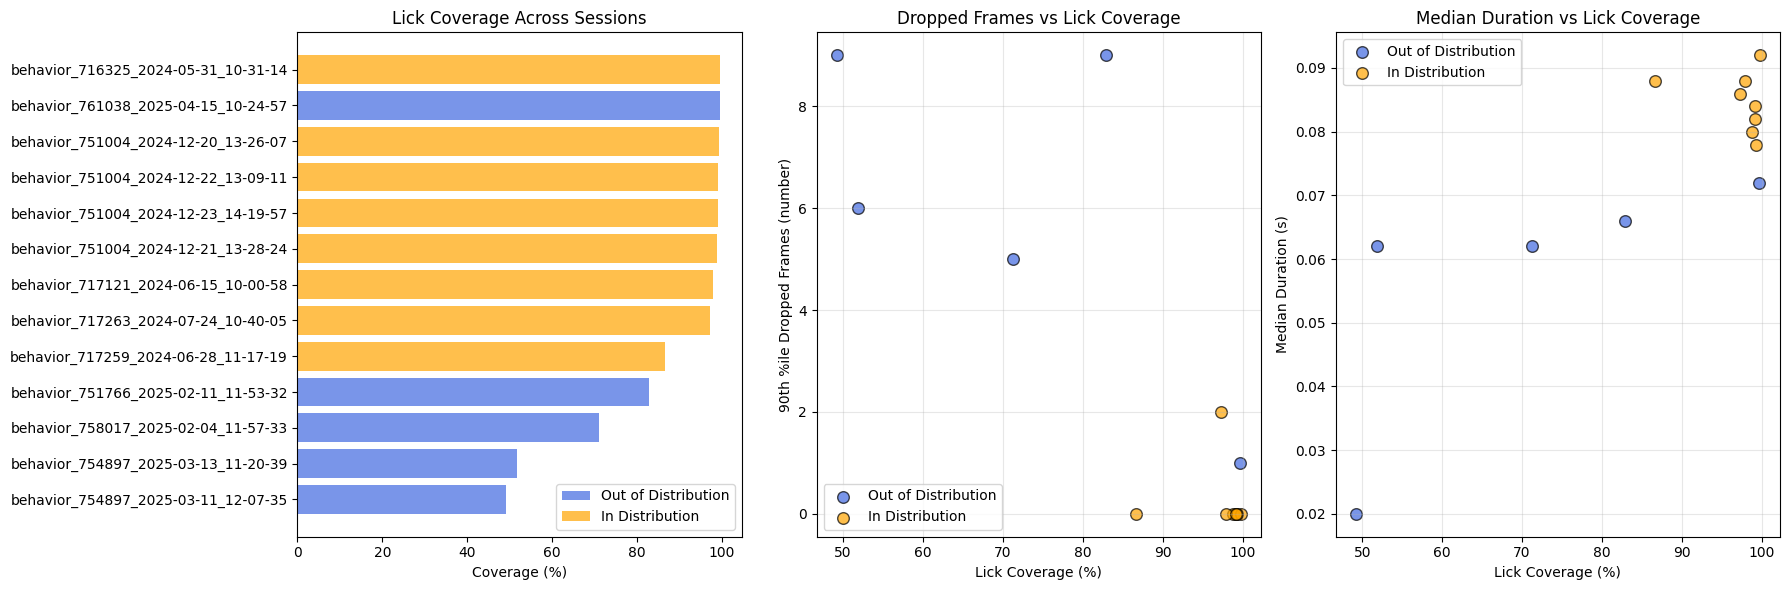

In [11]:
plot_combined_summary_compare(summary_df_ood, summary_df_id)

In [ ]:
from aind_dynamic_foraging_behavior_video_analysis.kinematics.video_clip_utils import process_and_label_clips

